# Projeto 2 de Ciência dos Dados

Integrantes:
- Barbara Martins Damasceno
- Daniel Costa Delattre 
- Guilherme Augusto Carvalho

## Objetivo 
**Pergunta que queremos responder**
Qual é o preço de uma casa de acordo com suas características?

Carregando algumas bibliotecas:

In [18]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os, csv, string, re
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest

In [19]:
### Função utilitária para fazer a regressão linear com constante adicionada
def regress(X,Y):
    '''
    X: coluna(s) do DataFrame que serão utilizadas como variável(is) preditoras/explicativas (independente(s))
    Y: coluna do DataFrame que será utilizada como variável resposta (dependente)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results


def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: ${:0.2f} .'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    # rf_random.fit(xtreino, ytreino)
    return accuracy

Carregando a base de dados de teste e de treino e excluindo as colunas date e zipcode (pois não serão usadas nas análise):

In [20]:
dados= pd.read_csv('datacasas.csv').drop(['date','zipcode'], axis=1)

In [21]:
#Printando as colunas que temos na variável do dataset
dados.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [22]:
dados.condition.describe()

count    21613.000000
mean         3.409430
std          0.650743
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64

Mas afinal, o que cada uma delas significa?
- **ID:**
- **Price:** Preço
- **Bedrooms:** Número de quartos
- **Bathrooms:** Números de banheiros
- **Sqft_living:** 
- **Sqft_lot:**
- **Floors:**
- **Waterfront:**
- **View:**
- **Condition:** Condição 0-5
- **Grade:** Classificação 
- **Sqft_above:**
- **Sqft_basement:**
- **Yr_built:** Ano de construção
- **Yr_renovated:** Ano de reconstrução/reforma
- **Lat:** Latitude
- **Long:** Longitude
- **Sqrt_living15:**
- **Sqrt_lot15:**

Verificando se não existe linhas sem dados/informação

In [23]:
np.sum(dados.isnull())

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Visualizando o dataset:

In [47]:
dados.head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503


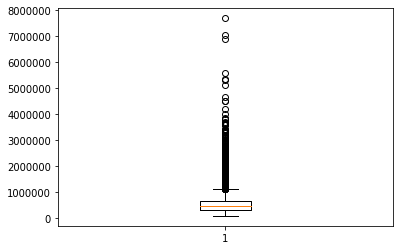

In [25]:
#Temos que ver se isso vai ser legal colocar ou não
plt.boxplot(dados['price'])
plt.show()

In [26]:
#removendo outliers
train = dados.copy()
clf = IsolationForest(max_samples = 110, random_state = 42)
clf.fit(train)
y_semout = clf.predict(train)
y_semout = pd.DataFrame(y_semout, columns = ['Top'])
y_semout[y_semout['Top'] == 1].index.values
train = train.iloc[y_semout[y_semout['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_semout[y_semout['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])
train.drop('id',axis = 1, inplace = True)
train.fillna(0,inplace=True)
dados = train

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Number of Outliers: 2162
Number of rows without outliers: 19451


# Analise exploratória 

Para visualizar o comportamento de cada variável do dataset (preço, número de banheiros, números de quartos, área da casa e do seu terreno, etc) foram plotados gráficos para identificar a distribuição de cada uma delas dentro do dataset. Além disso, como a variável de interesse para prever é o preço de casas, foram plotados alguns gráficos para visualizar a interação entre a coluna de preços das casas e as demais colunas. 

## Distribuição de cada variável

Abaixo está os gráficos da distribuição de cada variável, exceto da coluna com os preços, ela será analisada posteriormente:

Text(0, 0.5, 'Lote do terreno (square feet)')

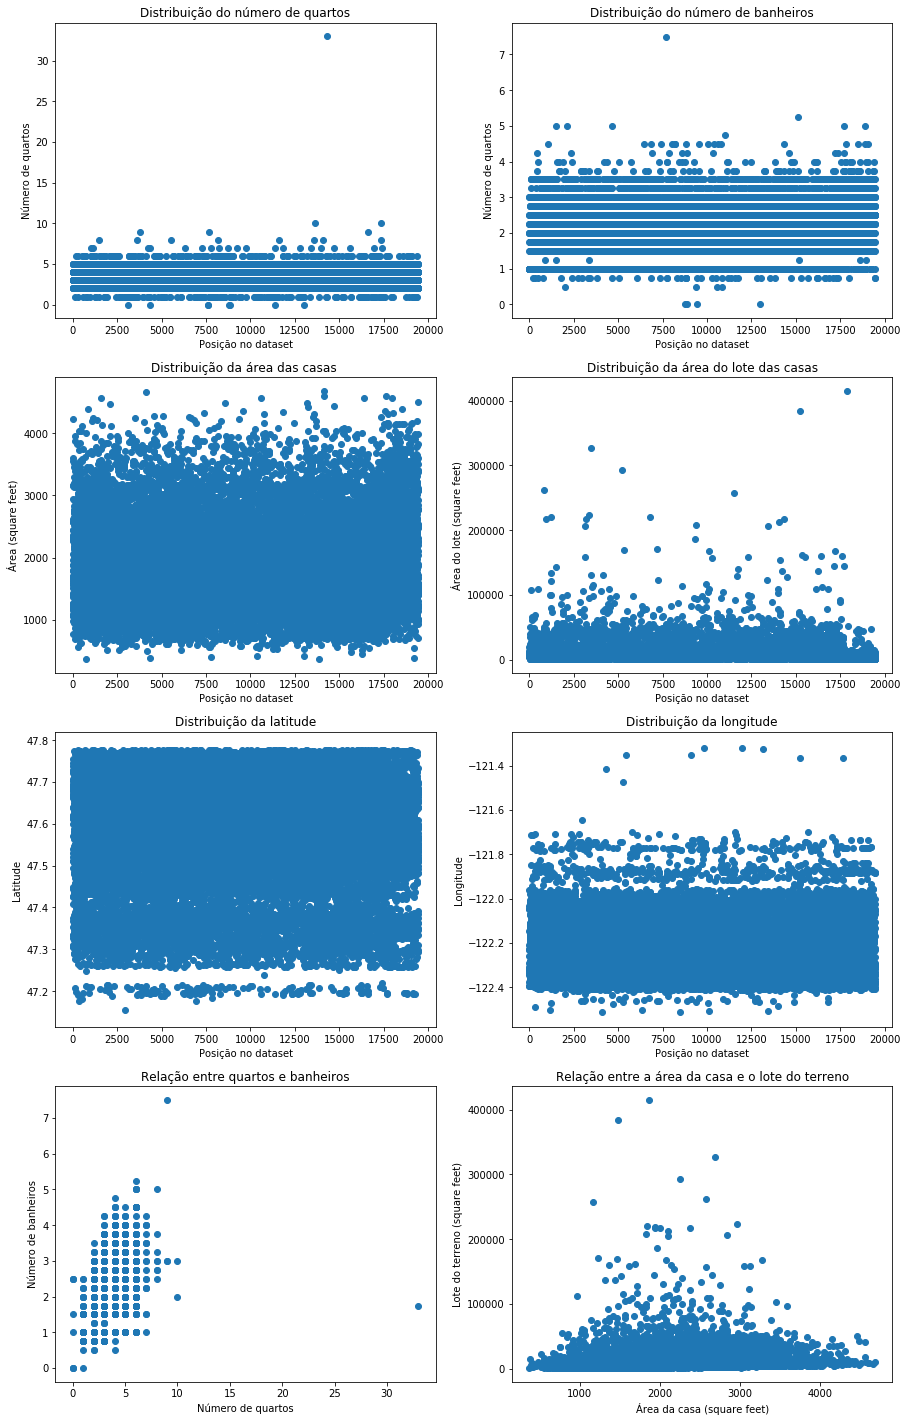

In [27]:
fig = plt.figure(figsize=(15, 25))

numero_linhas = np.arange(0,len(dados.price),1)

plt.subplot(4, 2, 1)
plt.scatter(numero_linhas,dados.bedrooms)
plt.title('Distribuição do número de quartos')
plt.xlabel("Posição no dataset")
plt.ylabel("Número de quartos")

plt.subplot(4, 2, 2)
plt.scatter(numero_linhas,dados.bathrooms)
plt.title('Distribuição do número de banheiros')
plt.xlabel("Posição no dataset")
plt.ylabel("Número de quartos")

plt.subplot(4, 2, 3)
plt.scatter(numero_linhas,dados.sqft_living)
plt.title('Distribuição da área das casas ')
plt.xlabel("Posição no dataset")
plt.ylabel("Área (square feet)")

plt.subplot(4, 2, 4)
plt.scatter(numero_linhas,dados.sqft_lot)
plt.title('Distribuição da área do lote das casas')
plt.xlabel("Posição no dataset")
plt.ylabel("Área do lote (square feet)")

plt.subplot(4, 2, 5)
plt.scatter(numero_linhas,dados.lat)
plt.title('Distribuição da latitude')
plt.xlabel("Posição no dataset")
plt.ylabel("Latitude")

plt.subplot(4, 2, 6)
plt.scatter(numero_linhas,dados.long)
plt.title('Distribuição da longitude')
plt.xlabel("Posição no dataset")
plt.ylabel("Longitude")

#Observando a relação entre o número de quartos e banheiros
plt.subplot(4,2,7)
plt.scatter(dados.bedrooms, dados.bathrooms)
plt.title('Relação entre quartos e banheiros')
plt.xlabel('Número de quartos')
plt.ylabel('Número de banheiros')

#Observando a relação entre a área da casa e o lote do terreno
plt.subplot(4,2,8)
plt.scatter(dados.sqft_living, dados.sqft_lot)
plt.title('Relação entre a área da casa e o lote do terreno')
plt.xlabel('Área da casa (square feet)')
plt.ylabel('Lote do terreno (square feet)')

Agora, iremos analisar a coluna do preço:

Text(0, 0.5, 'Preço da casa')

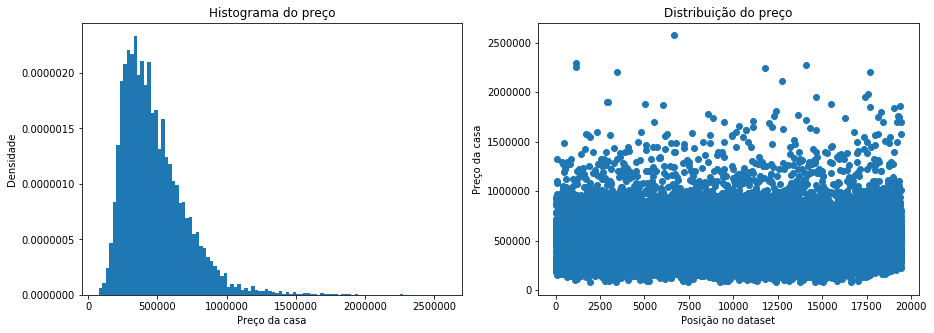

In [28]:
#Plotando as informações em gráficos
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(dados.price,bins=100,density=True)
plt.title('Histograma do preço')
plt.ylabel('Densidade')
plt.xlabel('Preço da casa')

plt.subplot(1, 2, 2)
faixa_aleatoria = np.arange(0,len(dados.price),1)
plt.scatter(faixa_aleatoria,dados.price)
plt.title('Distribuição do preço')
plt.xlabel('Posição no dataset')
plt.ylabel('Preço da casa')

#### Histograma do preço
O histograma se trata de gráfico que apresenta a distribuição de acordo com a frequência de uma amostra. Pode-se perceber que o histograma está deslocado a esquerda, mostrando que os preços dos dados se concentram até 1.000.000

#### Distribuição do preço
Esse gráfico cada ponto representa o valor de cada casa. Nele também percebe-se a concentração bem acentuada na faixa de 1 milhões e uma concentração mais leve entre 1 milhão e 2 milhões.

Como a variável de interesse para se prever é o preço, foi plotado gráficos cruzando os dados do preço com outras colunas:

Text(0, 0.5, 'Área do terreno')

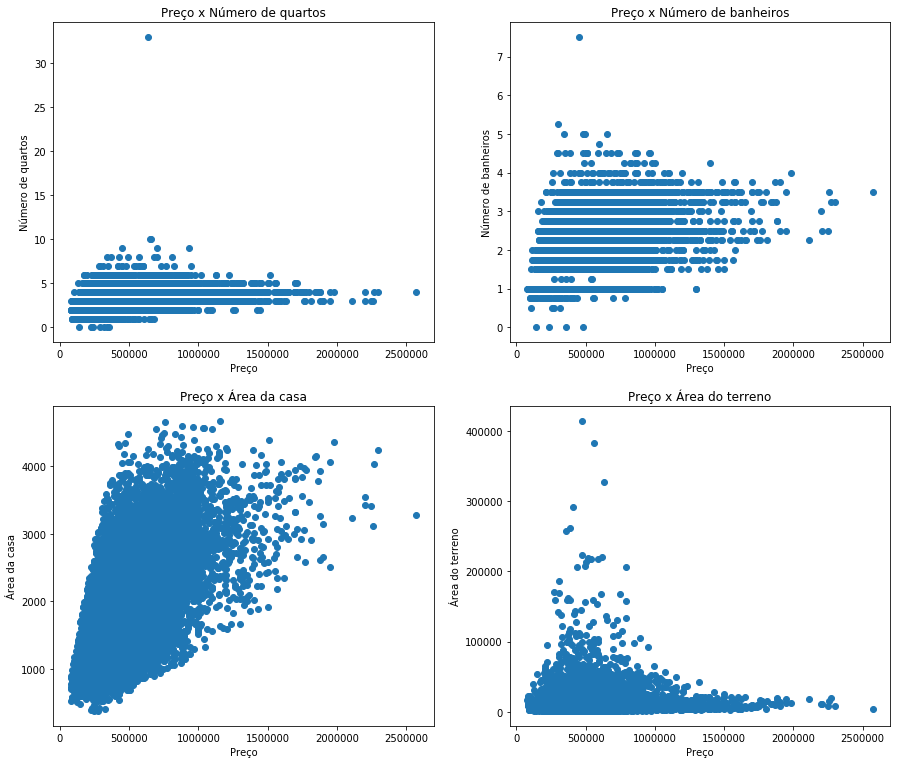

In [29]:
#Plotando as informações em gráficos
fig = plt.figure(figsize=(15, 20))

plt.subplot(3,2,3)
plt.scatter(dados.price, dados.bedrooms)
plt.title('Preço x Número de quartos')
plt.xlabel('Preço')
plt.ylabel('Número de quartos')

plt.subplot(3,2,4)
plt.scatter(dados.price, dados.bathrooms)
plt.title('Preço x Número de banheiros')
plt.xlabel('Preço')
plt.ylabel('Número de banheiros')

plt.subplot(3,2,5)
plt.scatter(dados.price, dados.sqft_living)
plt.title('Preço x Área da casa')
plt.xlabel('Preço')
plt.ylabel('Área da casa')

plt.subplot(3,2,6)
plt.scatter(dados.price, dados.sqft_lot)
plt.title('Preço x Área do terreno')
plt.xlabel('Preço')
plt.ylabel("Área do terreno")

# Predição por Regressão Linear Multipla

Assim como o próprio nome induz, o método faz a predição da variável de interesse (dependente) a partir de uma função **linear** com para cada uma das demais variáveis (independentes). A imagem abaixo apresenta a lei de formação da função: 

<img src="regressãolinear.png" width="360">

Essa função descreve a relação entre as variáveis de forma que a distância de cada relação com a função seja a menor possível, isso é feito por meio da minimização dos resíduos. O resíduo é a distância entro o valor da variável de interesse real do valor previsto pela função obtida. O cálculo do resíduo é feito por meio do **Método dos Mínimos Quadrados (MMQ)** ou, em inglês, _**Ordinary Least Squares**_. 



Definindo variável de interesse (preço) e demais que serão base para a predição:

In [69]:
#A variável de interesse é o preço, por isso selecionamos esta coluna no dataset
Y = dados['price']

#A variáveis dependentes serão bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, 
#grade, sqft_above,sqft_basement, yr_built, yr_renovated, lat, long, sqft_living15, sqft_lot15
X = dados[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','waterfront', 'condition', 'view', 'grade', 'sqft_above','sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long']]

In [70]:
#Printando as colunas que estão em X, apenas para confirmação
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'view', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long'],
      dtype='object')

Com a função regress, definida no início do documento, será gerado os resultados com auxílio da função OSL da biblioteca ``statsmodels.api`` 

In [71]:
results = regress(X,Y)

#Os resultados obtidos serão visualizados na tabela a seguir
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     2473.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:15:13   Log-Likelihood:            -2.5783e+05
No. Observations:               19451   AIC:                         5.157e+05
Df Residuals:                   19436   BIC:                         5.158e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.471e+07   1.17e+06    -21.102      0.000    -2.7e+07   -2.24e+07
bedrooms      -1.443e+04   1428.900    -10.098      0.000   -1.72e+04   -1.16e+04
bathrooms      2.922e+04   2505.125     11.665      0.000    2.43e+04    3.41e+04
sqft_living      71.3265      1.784     39.988      0.000      67.830      74.823
sqft_lot         -0.0573      0.080     -0.717      0.473      -0.214       0.099
floors         1.623e+04   2670.604      6.077      0.000     1.1e+04    2.15e+04
waterfront     1.835e+05   6.23e+04      2.948      0.003    6.15e+04    3.06e+05
condition      2.633e+04   1705.955     15.435      0.000     2.3e+04    2.97e+04
view            3.64e+04   1983.704     18.351      0.000    3.25e+04    4.03e+04
grade           9.46e+04   1574.442     60.085      0.000    9.15e+04    9.77e+04
sqft_above       49.7852      1.724     28.875      0.000      46.406      53.165
sqft_basement    21.5414      2.167      9.942      0.000      17.294      25.789
yr_built      -2100.7533     53.726    -39.101      0.000   -2206.061   -1995.446
yr_renovated     10.5375      3.268      3.225      0.001       4.133      16.942
lat            5.478e+05   7577.791     72.296      0.000    5.33e+05    5.63e+05
long          -1.807e+04   8792.259     -2.055      0.040   -3.53e+04    -838.679
==============================================================================
Omnibus:                     8650.904   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92701.456
Skew:                           1.855   Prob(JB):                         0.00
Kurtosis:                      13.031   Cond. No.                     9.64e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.6e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Análise da tabela

Na primeira linha, segunda coluna, da primeira tabela, está o coeficienete de determinação ou R². Ele se trata do coeficiente que apresenta a relação entre a função encontrada e os valores reais, ou seja, o "quão bem" a função acompanha os resultados reais. Ele pode ser obtido por:

$$ R^2 = 1 - \frac{SS_E}{SS_T}$$

Em que SSE e SST são:

$$SQRes=SS_{E}=\sum\limits^{n}_{i=1}(y_i-\hat{y}_i)^2=\sum\limits_{i=1}^{n}\epsilon^2_{i}$$

Lembrando que y é a variável de interesse, o preço da casa. Analisando a fórmula acima conclui-se que SSE é a somatória dos resíduos. Já SST é a somatória dos erros em torno da média, sem a aplciação da regressão:

$$SQT=SS_{T}=\sum\limits^{n}_{i=1}(y_i-\bar{y})^2$$


Dentro dos dados coletados, o **R² obtido é de 64%** assim, evidencia-se que o modelo de regressão linear múltipla não atinge um desempenho considerável, pois, não se aproxima do coeficiente de confiança estabelecido. 

É possível fazer a análise da **Homocedastidade**. Ela indica se o comportamento da variância se mantem a cada valor previsto. Para observá-la é necessário plotar o gráfico do valores preditos com os resíduos (erros), como na célula abaixo:  

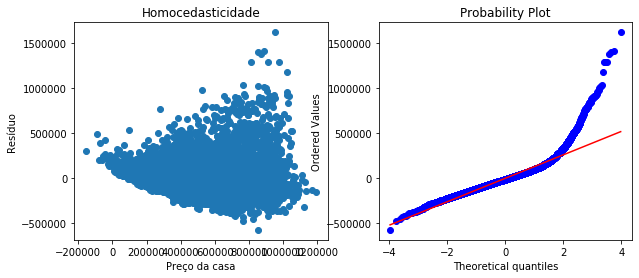

In [76]:
#Armazenando os resíduos obtidos
resultado_reg = results.resid

#Armazenando os valores de preço previstos
y_predict = results.predict(sm.add_constant(X))

fig1 = plt.figure(figsize=(10, 4))
#Verificando a Homocedasticidade
plt.subplot(1,2,1)
plt.scatter(y_predict,resultado_reg)
plt.title("Homocedasticidade")
plt.xlabel("Preço da casa")
plt.ylabel("Resíduo")

#Verificando se os resultados dos residuos obtidos por regressão apresentam distribuição normal
plt.subplot(1,2,2)
stats.probplot(resultado_reg,dist='norm',plot=plt)
plt.show()

Percebe-se que os valores preditos a homocedasticidade varia no modelo, assim, apresenta-se heteroscedasticidade nele. O gráfico da direito também evidência que há variação nos resíduos, pois não seguem a distribuição normal. Os valores de Prob(Omnibus) e Prob(JB) também evidenciam isso pois seus valores, encontrados na terceira tabela, são menores que alpha. 

Outra observação interesse, é sobre os valores-p para cada uma das variáveis independentes. Esse valor-p encontrado, se menor que alpha, mostra que aquela variável é relevante para a determinação do preço. Na tabela obtida, percebe-se que o tamanho do lote em square feet (legendada como sqft_lot) apresenta o valor-p de 0,473, se mostrando pouco relevante na predição do preço. Numa futura análise essa coluna poderia ser excluída, aplicar o modelo novamente para verficar se ele apresenta uma performace melhor.




# Predição por Decision Tree Regressor

Decision Tree Regressor ou Árvore de Decisão por Regressão é um modelo de predição, normalmente, usado quando a variável de interesse é do tipo contínua.  Para chegar no valor previsto ocorre um processo de tomada de decisões que saem de um ponto de partida e se dividem em outros subconjuntos, ou seja ramificações, assim como as raízes de uma árvore. O ponto de partida é o conjunto com todos dados das variáveis influentes sob a variável de interesse, dentro do modelo ele é chamado de nó raiz.  A separação em subconjuntos é chamado de divisão. Já os subconjuntos podem ser nó de decisão ou (conseguirá criar outros subconjuntos) ou nó de término. Quando um nó gera subconjuntos, ele pode ser chamado de nó pai e seus “descendentes”, os subconjuntos, são chamados de nós filhos, assim como na árvore genealógica.  A figura abaixo apresenta como seria a árvore de decisão:

<img src="decisiontree.png" width="500">

Dentro do projeto, o nó raiz são os dados, as sub-árvores são as colunas com as variáveis que interferem para prever o preço da casa e as demais divisões que surgem a partir das colunas e a interação entre elas em cada sub-árvore são feitas na biblioteca sklearn.DecisionTreeRegressor. As próximas células apresentam a implementação da Decision Tree Regressor por meio da biblioteca:


Escolhendo as colunas que serão usadas como parâmetros:

In [105]:
#antigo
# features = ['bedrooms', 'bathrooms', 'sqft_living',
#        'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
#        'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15',
#        'lat', 'long',]

features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']

Renomeando quem será a variável de interesse (preço) e as features. Além de separar o banco de dados entre teste e treinamento:

In [106]:
y = dados.price
x = dados[features]
xtreino,xvalidacao,ytreino,yvalidacao = train_test_split(x, y, random_state=1)

In [107]:
# Especificando o modelo
modelo_decisiontree = DecisionTreeRegressor()
# Fit do modelo 
modelo_decisiontree.fit(xtreino, ytreino)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [108]:
# Faz a previsão do preço das casas e calcula a média dos erros com base 
val_predictions = modelo_decisiontree.predict(xvalidacao)
val_mae = mean_absolute_error(val_predictions, yvalidacao)
print(f'MAE: {val_mae:.2f}')

MAE: 73824.36


# Predição por Random Forest

~Explicar sobre o que é e como funciona o método

In [109]:
#modelo usando random forest 
modelo_randomforest = RandomForestRegressor(random_state=1)
modelo_randomforest.fit(xtreino, ytreino)
rf_predict = modelo_randomforest.predict(xvalidacao)
rf_mae = mean_absolute_error(rf_predict, yvalidacao)

print(f'Random Forest MAE: {rf_mae:.2f}')

Random Forest MAE: 51345.31


Esse gŕafico mostra a relação entre os valores previstos e os valores reais

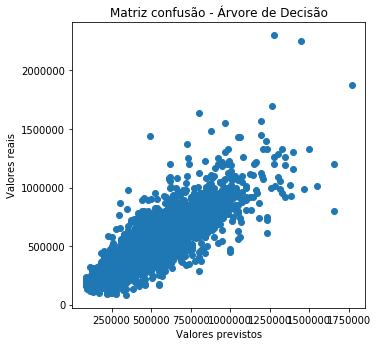

In [110]:
fig1 = plt.figure(figsize=(5.25,5.25))
plt.scatter(val_predictions,yvalidacao)
plt.title("Matriz confusão - Árvore de Decisão")
plt.xlabel("Valores previstos")
plt.ylabel('Valores reais')
plt.show()

In [111]:
dados = train
# y = dados.price
# x = dados[features]
xtreino,xvalidacao,ytreino,yvalidacao = train_test_split(x, y, random_state=1)
# Especificando o modelo
modelo_decisiontree = DecisionTreeRegressor()
# Fit do modelo 
modelo_decisiontree.fit(xtreino, ytreino)
# Faz a previsão do preço das casas e calcula a média dos erros com base 
val_predictions = modelo_decisiontree.predict(xvalidacao)
val_mae = mean_absolute_error(val_predictions, yvalidacao)
print(f'MAE Decision Tree sem outliers: {val_mae:.2f}')

MAE Decision Tree sem outliers: 73825.57


Random Forest sem outliers

In [ ]:
#modelo usando random forest 
modelo_randomforest = RandomForestRegressor(random_state=1,n_jobs=6,n_estimators=2000,min_samples_split=5,min_samples_leaf=2,max_features='auto',max_depth=50,bootstrap=True)
modelo_randomforest.fit(xtreino, ytreino)
rf_predict = modelo_randomforest.predict(xvalidacao)
rf_mae = mean_absolute_error(rf_predict, yvalidacao)

print(f'Random Forest MAE sem outliers: {rf_mae:.2f}')

In [ ]:
base_accuracy = evaluate(modelo_randomforest, xvalidacao, yvalidacao)

# Essa parte era pra tunar o modelo

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(modelo_randomforest.get_params())


In [ ]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -2)
# # Fit the random search model
# rf_random.fit(xtreino, ytreino)

In [ ]:
# rf_random.best_params_

In [ ]:
dic = {'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

for k,v in dic.items():
    print(f'{k}={v}')